<a href="https://colab.research.google.com/github/mitsu666/blog/blob/master/020_MMM_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pystan
import pandas as pd
import numpy as np
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('mmm_sample_1.csv')

In [ ]:
df = df.set_index('Date')

In [ ]:
df.head(20)

,month,TV,NP,TV_1,TV_2,TV_3,sales
Date,,,,,,,
2017-01-04,1,1248.393087,518.032149,1215.978440,1435.101373,1418.765543,1919.040672
2017-01-05,1,1246.928981,517.073342,1248.393087,1215.978440,1435.101373,2062.992804
2017-01-06,1,1116.338667,0.000000,1246.928981,1248.393087,1215.978440,1760.464395
2017-01-07,1,1264.389602,527.270584,1116.338667,1246.928981,1248.393087,1966.503560
2017-01-08,1,1293.714902,505.352452,1264.389602,1116.338667,1246.928981,1873.343144
2017-01-09,1,1178.207720,0.000000,1293.714902,1264.389602,1116.338667,1799.841992
2017-01-10,1,1270.310377,0.000000,1178.207720,1293.714902,1264.389602,1723.575469
2017-01-11,1,0.000000,0.000000,1270.310377,1178.207720,1293.714902,1398.152831
2017-01-12,1,1216.552351,534.773929,0.000000,1270.310377,1178.207720,1663.189437


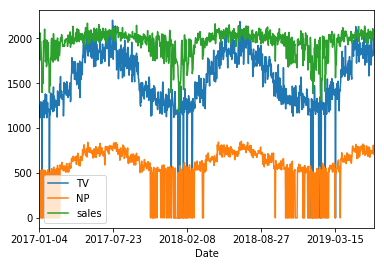

In [ ]:
df[['TV','NP','sales']].sort_index().plot()

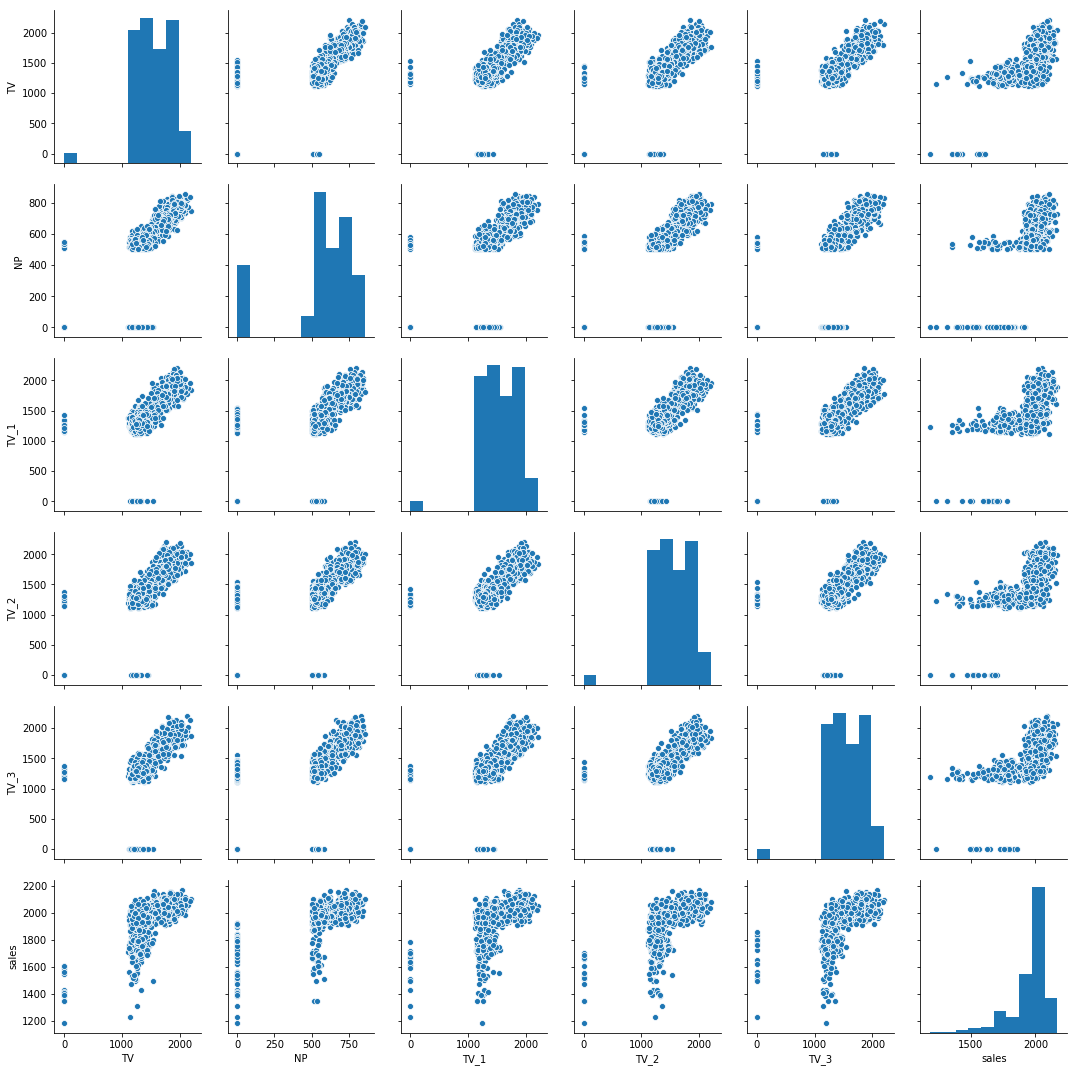

In [ ]:
sns.pairplot(df[['TV','NP','TV_1','TV_2','TV_3','sales']])

In [ ]:
#説明変数と目的変数整理
X = df[['TV','NP','TV_1','TV_2','TV_3']]
y = df['sales']

In [ ]:
#pystanの準備

model = """
data {
  int<lower=0> N;
  vector[N] TV;
  vector[N] TV_1;
  vector[N] TV_2;
  vector[N] TV_3;
  vector[N] NP;
  vector[N] y;
}
parameters { 
  real beta_0;
  real beta_1;
  real beta_2;
  real<lower=0, upper=1> lambda;
  real<lower=0> sigma;
}

model { 
  for (i in 1:N)
      y[i] ~ normal(beta_0 + beta_1 * (log(TV[i]+1)+log(lambda * TV_1[i]+1)+log(lambda^(2) * TV_2[i]+1)+log(lambda^(3) * TV_3[i]+1)) +log( NP[i]+1)* beta_2 , sigma);
}
"""

In [ ]:
#pystanに食わせるデータ定義（辞書型）
dat = {'N':len(X), 'TV': X['TV'].values,'TV_1': X['TV_1'].values,'TV_2': X['TV_2'].values,'TV_3': X['TV_3'].values,'NP': X['NP'].values, 'y': y.values}
#MCMC実行
fit = pystan.stan(model_code=model, data=dat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_542e93b340e252b887c39c59a124a725 NOW.


In [ ]:
fit

Inference for Stan model: anon_model_542e93b340e252b887c39c59a124a725.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_0 671.21    0.39  19.87  632.8 657.96 671.18 684.82 709.93   2542    1.0
beta_1  49.77    0.02   1.22  47.35  48.95  49.78  50.59   52.2   2488    1.0
beta_2  31.13    0.01   0.74  29.65  30.64  31.14  31.63  32.55   2991    1.0
lambda   0.33  5.6e-4   0.03   0.28   0.31   0.33   0.35   0.39   2655    1.0
sigma   47.35    0.02   1.09  45.19  46.59  47.31  48.05  49.65   3156    1.0
lp__    -3953    0.04   1.58  -3957  -3954  -3953  -3952  -3951   1870    1.0

Samples were drawn using NUTS at Fri Aug  9 13:07:02 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

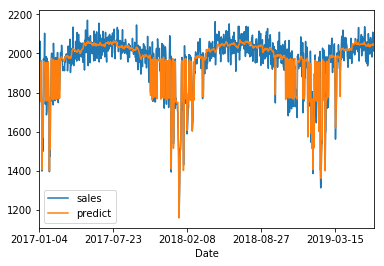

In [ ]:
param = fit.get_posterior_mean().mean(axis=1)
df['predict'] = param[0]+param[1]*(np.log(df['TV']+1)+np.log(param[3]*df['TV_1']+1)+
                   +np.log(param[3]**(2)*df['TV_2']+1)+np.log(param[3]**(3)*df['TV_3']+1))+param[2]*np.log(df['NP']+1)
df[['sales','predict']].sort_index().plot()